# Predicting mode choice behavior based on person characteristics

Members & Student numbers: Willemijn ten Voorden (6101275), Frederiek Backers (4704452), Annerieke Ohm (4852990), Nikolaos Tsironis (6008712)

# Research Objective
This research proposal is made for the TIL Programming TIL6022 course project. We focus on an application project on mobility trends in The Netherlands using open-source data, making this a societal project. We were inspired by the current discussions on introducing rush hour tax for train tickets in the Netherlands [1]. Looking at the discussion, we were wondering if there are certain personal characteristics that can be related to mode choice behavior. This resulted in the following research question:

**How do personal characteristics influence mode choice behaviour of adult travellers in The Netherlands during the years 2018-2022?**

To answer this research question we will do some data processing, quantitative analysis and visualize our results. To be able to answer our research question, we present some subquestions:

1. *What is the probability for a person to choose a certain transport mode based on one personal characteristic?*
2. *From the previous subquestion, which personal characteristics jump out and could be researched further?*
3. *Is there a significant difference over the years in mode choice?*
4. *Can we use machine learning methods to classify which personal characteristics correlate the most with the various modes?*


For every subquestion we do the following quantitative analysis and visualisations:
1. Use probability theory, make plots and interpret results.
2. Make (interactive) plots for various personal charactertics and elaborate on the results.
3. .....
4. We use K-means clustering to cluster the data into k clusters. The number of clusters k is determined by using the Elbow method and checking the BIC, Silhouette and Davies scores. Then we cluster the data and check the correlation between the clusters and the mode choices, and check which personal characteristics belong to which cluster.

The data is obtained from CBS (Central Bureau for Statistics Netherlands) that includes mode choice and personal characteristics of individuals. The data will be explained more thoroughly in the data section.

# Contribution Statement

*Be specific. Some of the tasks can be coding (expect everyone to do this), background research, conceptualisation, visualisation, data analysis, data modelling*

**Willemijn**:

**Nick**:

**Annerieke**:

**Frederiek**:

# Data Used

For this research project we use one dataset obtained from CBS that includes mode choice and personal characteristics of individuals:

*StatLine - Mobiliteit; per persoon, persoonskenmerken, vervoerwijzen en regio's (cbs.nl)* [2]

The dataset contains information about the travel behavior of the Dutch population aged 6 and older in private households, excluding residents of institutions and homes. The data includes the number of trips, distance traveled and average travel duration per person, per day and per year. It covers regular movements within the Netherlands, including domestic vacation mobility. Series movements are not considered regular movements. The data from years 2018-2022 is used.

Travel behavior is broken down into personal characteristics, modes of transportation, population, gender and regions. To slim the dataset this study only focuses on the average number of trips for every mode per day, for every person characteristic. We use only certain personal characteristics such as income, migration background, education level, participation and availability of a student PT card and drivers license, next to gender and age. Some other scale limitations are:
- Geographical boundary: the Netherlands
- Travel modes: car, public transport, active modes and other modes
- Time scale: 2018-2022
- Ages: 18 years and older



# Data Pipeline

## Import packages

In [2]:
import os
import pandas as pd
%matplotlib inline
import pandas as pd
import numpy as np
import math
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from plotly.subplots import make_subplots
from IPython.display import display

# packages for machine learning method k-means clustering
from sklearn import preprocessing
from sklearn.metrics import classification_report
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.mixture import GaussianMixture

## Import data

In [4]:
file_path = "/Users/nicktsironis/Documents/GitHub/TIL6022Project/" + "Data.csv"

# read data: remove first 6 rows and last row that do not contain data
data = pd.read_csv(file_path, delimiter = ';', skiprows = 6, skipfooter = 1, engine = 'python')

## Data processing

In [5]:
# make person characteristics index
data.set_index('Vervoerwijzen', inplace = True)

# remove rows with missing information
data_updated = data.drop(labels = ["Persoonskenmerken", "Totaal personen", "Leeftijd:6 tot 12 jaar", "Leeftijd: 12 tot 18 jaar", 
                                       "Participatie: werkloos", "Participatie:  arbeidsongeschikt", "Geen rijbewijs; jonger dan 17 jaar", "OV-Studentenkaart: weekendabonnement"])

# replace dots in dataset with 0
data_updated = data_updated.replace('.', 0)

# only keep columns with average number of movements per day per person
columns_to_keep = [col for col in data_updated.columns if data_updated.loc["Onderwerp", col] == "Gemiddeld per persoon per dag |Verplaatsingen "]
data_updated = data_updated[columns_to_keep]

#Remove the "onderwerp" row, since this is now the same for all columns
data_updated = data_updated.drop("Onderwerp")

# the data is formatted as strings, we convert these to floats and make NaN's equal to 0 for all three dataframes
def preprocess_dataframe(df):
    # Convert strings to floats and replace NaN values with 0
    df = df.apply(lambda col: col.str.replace(',', '.').astype(float).fillna(0))
    return df

data_updated = preprocess_dataframe(data_updated)

#Merge the rows "Leeftijd: 65 tot 75 jaar" en "75jaar of ouder" into one row
data_updated = (data_updated.reset_index()
                .replace({"Vervoerwijzen": {"Leeftijd: 75 jaar of ouder" : "Leeftijd: 65 tot 75 jaar"}})
                .groupby("Vervoerwijzen", sort=False).sum()
)
data_updated = data_updated.rename({"Leeftijd: 65 tot 75 jaar" : "Leeftijd: 65 jaar of ouder"})

#Split dataframe into 5 separate datframes: one for each year and remove row "perioden"
columns_2018 = [col for col in data_updated.columns if int(data_updated.loc["Perioden", col]) == 2018]
columns_2019 = [col for col in data_updated.columns if int(data_updated.loc["Perioden", col]) == 2019]
columns_2020 = [col for col in data_updated.columns if int(data_updated.loc["Perioden", col]) == 2020]
columns_2021 = [col for col in data_updated.columns if int(data_updated.loc["Perioden", col]) == 2021]
columns_2022 = [col for col in data_updated.columns if int(data_updated.loc["Perioden", col]) == 2022]
transport_2018 = data_updated[columns_2018].drop("Perioden")
transport_2019 = data_updated[columns_2019].drop("Perioden")
transport_2020 = data_updated[columns_2020].drop("Perioden")
transport_2021 = data_updated[columns_2021].drop("Perioden")
transport_2022 = data_updated[columns_2022].drop("Perioden")

#Merge car driver and passenger into car, cycle and walk into active modes and trainand bus/tram/metro into public transport
def merge_transport_categories(df):
    #The different years have a number behind the column names. Remove these numbers.
    column_names = ["Total", "Personenauto (bestuurder)", "Personenauto  (passagier)", 
                    "Trein", "Bus/tram/metro", "Fiets", "Lopen", "Overige vervoerwijze"]
    df.columns = column_names
    #Merge desired columns
    df["Passengercar"] = df["Personenauto (bestuurder)"] + df["Personenauto  (passagier)"]
    df["Public Transport"] = df["Trein"] + df["Bus/tram/metro"]
    df["Active modes"] = df["Fiets"] + df["Lopen"]
    df = df.drop(columns = ["Personenauto (bestuurder)", "Personenauto  (passagier)", "Trein", "Bus/tram/metro", "Fiets", "Lopen"])
    #Move "Overige vervoerswijze" to the end of the dataframe
    Other = df.pop("Overige vervoerwijze")
    df["Other modes"] = Other
    #Translate all index names to English
    index_names = ["Age: 18 to 25 years", "Age: 25 to 35 years", "Age: 35 to 50 years", "Age: 50 to 65 years", 
                   "Age: 65 years or older", "Migrationbackground: The Netherlands", "Migrationbackground: Western", 
                   "Migrationbackground: Non-western", "Standardised income: 1st 20% group", "Standardised income: 2nd 20% group",
                   "Standardised income: 3rd 20% group", "Standardised income: 4th 20% group", 
                   "Standardised income: 5th 20% group", "PT-studentcard: Weekday subscription", "PT-studentcard: None",
                   "Education level: Low", "Education level: middle", "Education level: High", "Participation: Working 12 to 30 h/w",
                   "Participation: Working 30+ h/w", "Participation: student", "Participation: retired",
                   "Participation: Other", "Drivers licence; owns own car", "Drivers license; car in household",
                   "Drivers license; no car", "No drivers license"]
    df.index = index_names

    return df

transport_2018 = merge_transport_categories(transport_2018)
transport_2019 = merge_transport_categories(transport_2019)
transport_2020 = merge_transport_categories(transport_2020)
transport_2021 = merge_transport_categories(transport_2021)
transport_2022 = merge_transport_categories(transport_2022)

In [23]:
#Example of what a dataset now looks like. Layout the same for all years, only numbers might differ.
transport_2020

,Total,Passengercar,Public Transport,Active modes,Other modes
Age: 18 to 25 years,2.23,0.89,0.21,1.04,0.09
Age: 25 to 35 years,2.43,1.18,0.10,1.07,0.07
Age: 35 to 50 years,2.77,1.43,0.06,1.17,0.11
Age: 50 to 65 years,2.50,1.21,0.04,1.12,0.12
Age: 65 years or older,3.48,1.48,0.02,1.88,0.09
Migrationbackground: The Netherlands,2.52,1.15,0.05,1.22,0.10
Migrationbackground: Western,2.02,0.80,0.09,1.06,0.07
Migrationbackground: Non-western,1.65,0.66,0.13,0.80,0.05
Standardised income: 1st 20% group,1.88,0.58,0.10,1.13,0.09
Standardised income: 2nd 20% group,2.08,0.85,0.06,1.08,0.08


# Data analysis

Write small introduction here.

### Subquestion 1: What is the probability for a person to choose a certain transport mode based on one personal characteristic?
To answer this question, the data is normalised per personal characteristic. This way, the numbers in the dataset become independent of how much a certain group travels and instead shows the distribution of the group's travels over the different modes. This is then visualised using stacked barplots, allowing for comparison between the different groups. This is done for each year separately, allowing for both comaprison within one year as well as comparison between the different years.

In [21]:
#Normalise dataframe rows
def normal_rows(df):
    normal_df = df.drop(columns = ["Total"])
    normal_df = normal_df.div(normal_df.sum(axis = 1), axis = 0)
    return normal_df

normal_2018 = normal_rows(transport_2018)
normal_2019 = normal_rows(transport_2019)
normal_2020 = normal_rows(transport_2020)
normal_2021 = normal_rows(transport_2021)
normal_2022 = normal_rows(transport_2022)

normal_2022

,Passengercar,Public Transport,Active modes,Other modes
Age: 18 to 25 years,0.367188,0.132812,0.445312,0.054688
Age: 25 to 35 years,0.476015,0.059041,0.431734,0.033210
Age: 35 to 50 years,0.491857,0.029316,0.439739,0.039088
Age: 50 to 65 years,0.470175,0.021053,0.459649,0.049123
Age: 65 years or older,0.415704,0.011547,0.545035,0.027714
Migrationbackground: The Netherlands,0.439024,0.027875,0.491289,0.041812
Migrationbackground: Western,0.363248,0.059829,0.547009,0.029915
Migrationbackground: Non-western,0.383495,0.106796,0.475728,0.033981
Standardised income: 1st 20% group,0.305310,0.075221,0.575221,0.044248
Standardised income: 2nd 20% group,0.391837,0.040816,0.522449,0.044898


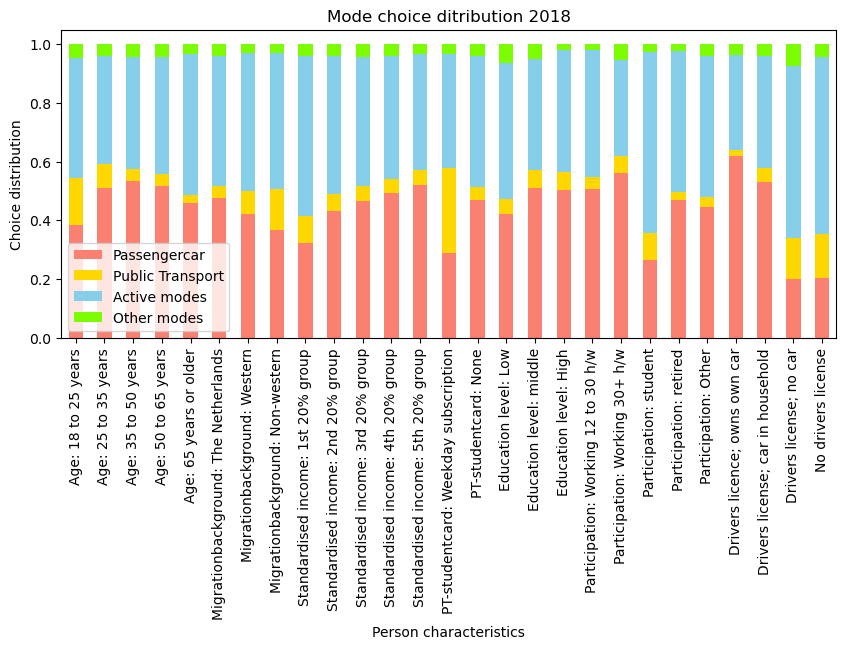

In [6]:
normal_2018.plot(kind = "bar", stacked = True, color = ["salmon", "gold", "skyblue", "lawngreen"], 
                  figsize = (10,4), fontsize = 10)
plt.title("Mode choice ditribution 2018")
plt.xlabel("Person characteristics")
plt.ylabel("Choice distribution")
plt.show()

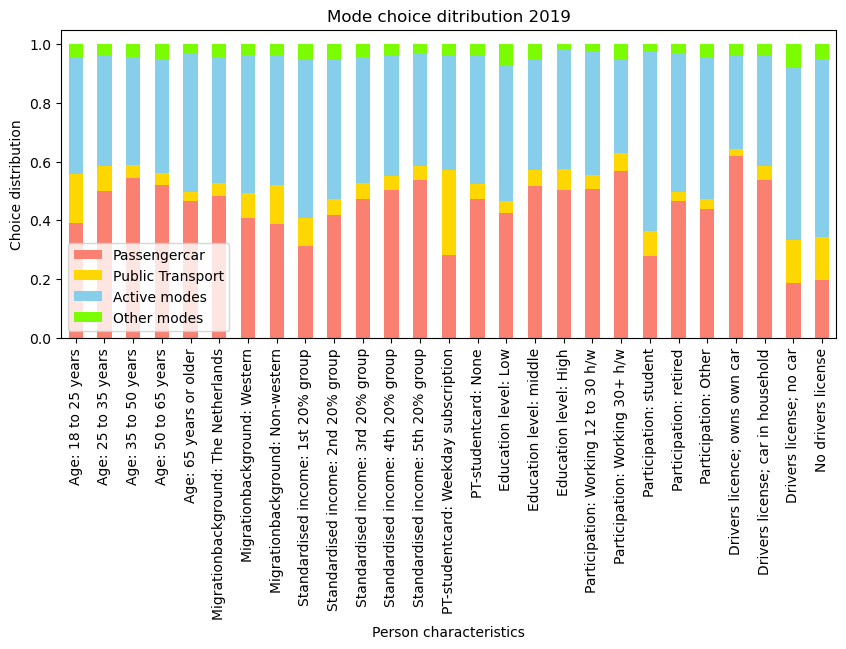

In [7]:
normal_2019.plot(kind = "bar", stacked = True, color = ["salmon", "gold", "skyblue", "lawngreen"], 
                  figsize = (10,4), fontsize = 10)
plt.title("Mode choice ditribution 2019")
plt.xlabel("Person characteristics")
plt.ylabel("Choice distribution")
plt.show()

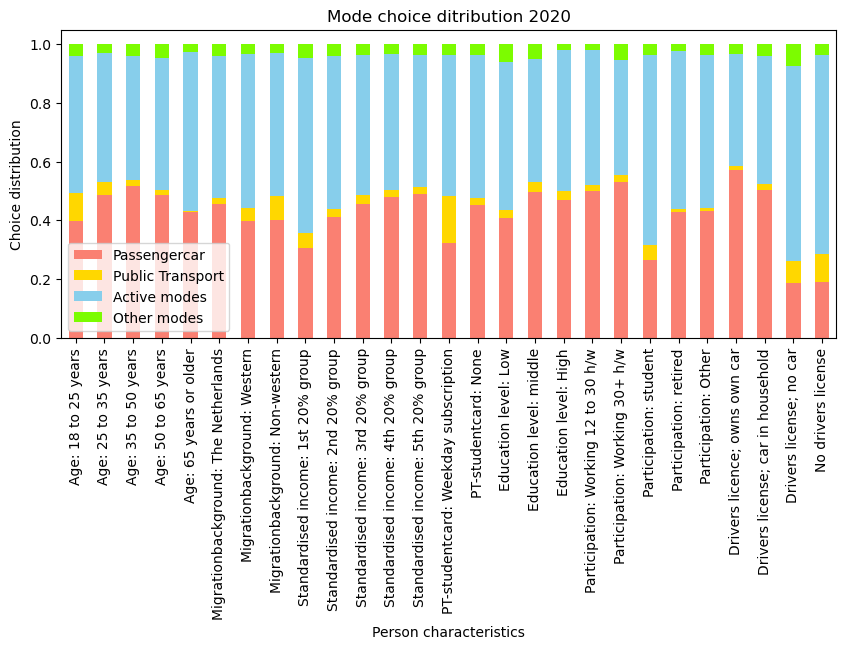

In [8]:
normal_2020.plot(kind = "bar", stacked = True, color = ["salmon", "gold", "skyblue", "lawngreen"], 
                  figsize = (10,4), fontsize = 10)
plt.title("Mode choice ditribution 2020")
plt.xlabel("Person characteristics")
plt.ylabel("Choice distribution")
plt.show()

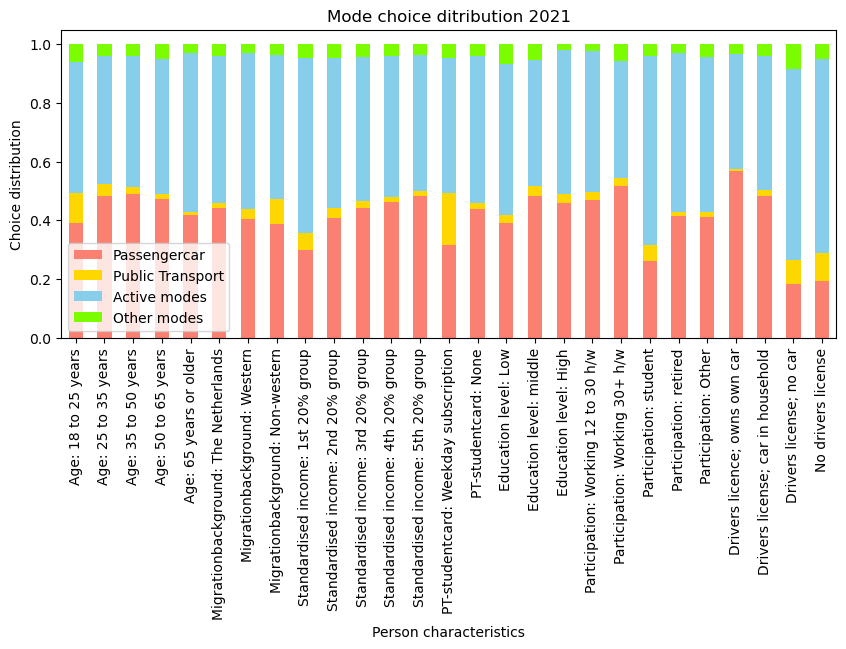

In [9]:
normal_2021.plot(kind = "bar", stacked = True, color = ["salmon", "gold", "skyblue", "lawngreen"], 
                  figsize = (10,4), fontsize = 10)
plt.title("Mode choice ditribution 2021")
plt.xlabel("Person characteristics")
plt.ylabel("Choice distribution")
plt.show()

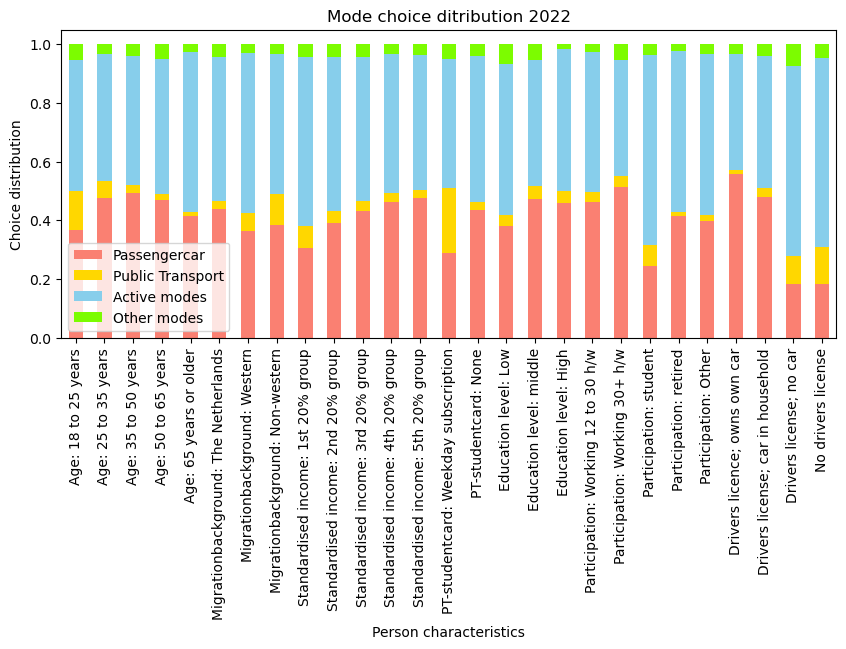

In [10]:
normal_2022.plot(kind = "bar", stacked = True, color = ["salmon", "gold", "skyblue", "lawngreen"], 
                  figsize = (10,4), fontsize = 10)
plt.title("Mode choice ditribution 2022")
plt.xlabel("Person characteristics")
plt.ylabel("Choice distribution")
plt.show()

Some things that immediately jump out based on these plots:
- The group with a PT-studentcard is using much more public transport than any other group.
- Movements by car seem to often be replaced by active modes for (on average) lower-income groups (low income, students, peopple with a migration background).
- There doesn't seem to be much difference between having a drivers license, but no car and not having a drivers license at all.
- The share of public transport during the covid years (2020, 2021) doesn't decrease as much as one might expect.

These and other points and possible explanations for them, will be research later in this report.

### Subquestion 2: From the previous subquestion, which personal characteristics jump out and could be researched further?

#### Age groups
The following code shows five bar plots that compare the mode of transport of the five different age groups. Each plot shows the percentage of transport mode choices per age group every year. 
**How does the use of public transport vary by age?**

In [16]:
import plotly.express as px

# Define the list of years
years = [2018, 2019, 2020, 2021, 2022]

# Define the list of age groups to keep
age_groups_to_keep = [
    "Age: 18 to 25 years",
    "Age: 25 to 35 years",
    "Age: 35 to 50 years",
    "Age: 50 to 65 years",
    "Age: 65 years or older"
]

# Define the desired colors
custom_colors = ["salmon", "gold", "skyblue", "lawngreen"]

# Create a separate plot for each year
for year in years:
    if year == 2018:
        year_df = transport_2018
    elif year == 2019:
        year_df = transport_2019
    elif year == 2020:
        year_df = transport_2020
    elif year == 2021:
        year_df = transport_2021
    else:
        year_df = transport_2022

    # Remove the "Total" column
    year_df = year_df.drop("Total", axis=1)

    # Calculate the percentage of transportation mode used by each age group
    total_per_age_group = year_df.sum(axis=1)
    percentage_df = year_df.divide(total_per_age_group, axis=0) * 100

    # Keep only the specified age groups
    percentage_df = percentage_df.loc[age_groups_to_keep]

    # Create an interactive bar chart for the current year
    fig = px.bar(
        percentage_df,
        x=percentage_df.index,  # Use the age groups as x-axis categories
        y=percentage_df.columns,
        labels={"value": "Percentage", "index": "Age Group"},
        color_discrete_sequence=custom_colors,  # Use custom colors
        title=f"Modes of Transportation by Age Group ({year})"
    )

    # Show the interactive plot
    fig.show()

**Transport Modes**

Over the years, different age groups have exhibited distinct preferences for modes of transportation. Younger individuals (18 to 25 years) often favor public transport and active modes (cycling and walking), while older age groups (35 to 50 years and 50 to 65 years) tend to rely heavily on passenger cars.

The data consistently highlights that two age groups, particularly those aged 35 to 50 years and 50 to 65 years or older, exhibit a strong reliance on passenger cars. This mode of transportation accounts for a significant proportion of their trips.

Public transport was generally popular among the 18 to 25-year-old age group, although its popularity fluctuated slightly from year to year. In contrast, public transport was less favored among older age groups.

Active modes, including cycling and walking, exhibit some year-to-year variability in popularity, primarily among the 18 to 25-year-old age group and the 65 years and older group.

Passenger cars remained a prevalent choice among individuals aged 25 to 65 years, consistently making up a significant portion of their trips.It is noteworthy that passenger cars remain a prominent choice for all age groups other than the youngestand the oldest age groups. This highlights the continued relevance of personal vehicles in people's lives, regardless of their age.

While public transport is the preferred choice of the 18 to 25-year-old age group, there are some fluctuations in its popularity across the years. 

**Trend**

The main trend highlighted in the chart is the age-dependent variation in transportation preferences. Younger individuals tend to prefer public transport and active modes like cycling and walking, while older age groups rely more heavily on passenger cars. The consistent reliance on passenger cars by individuals aged 35 to 65 years underscores the enduring significance of personal vehicles in people's lives. Also the active modes are significant for the age group of 65 and older during the years. 





#### Income groups
The following code shows five bar plots that compare the mode of transport & the different income groups for each year. Each plot shows the distribution of transport mode choiches per income group compared to the total number of average movements per day. **Does the choice of transport mode differ between income groups?**

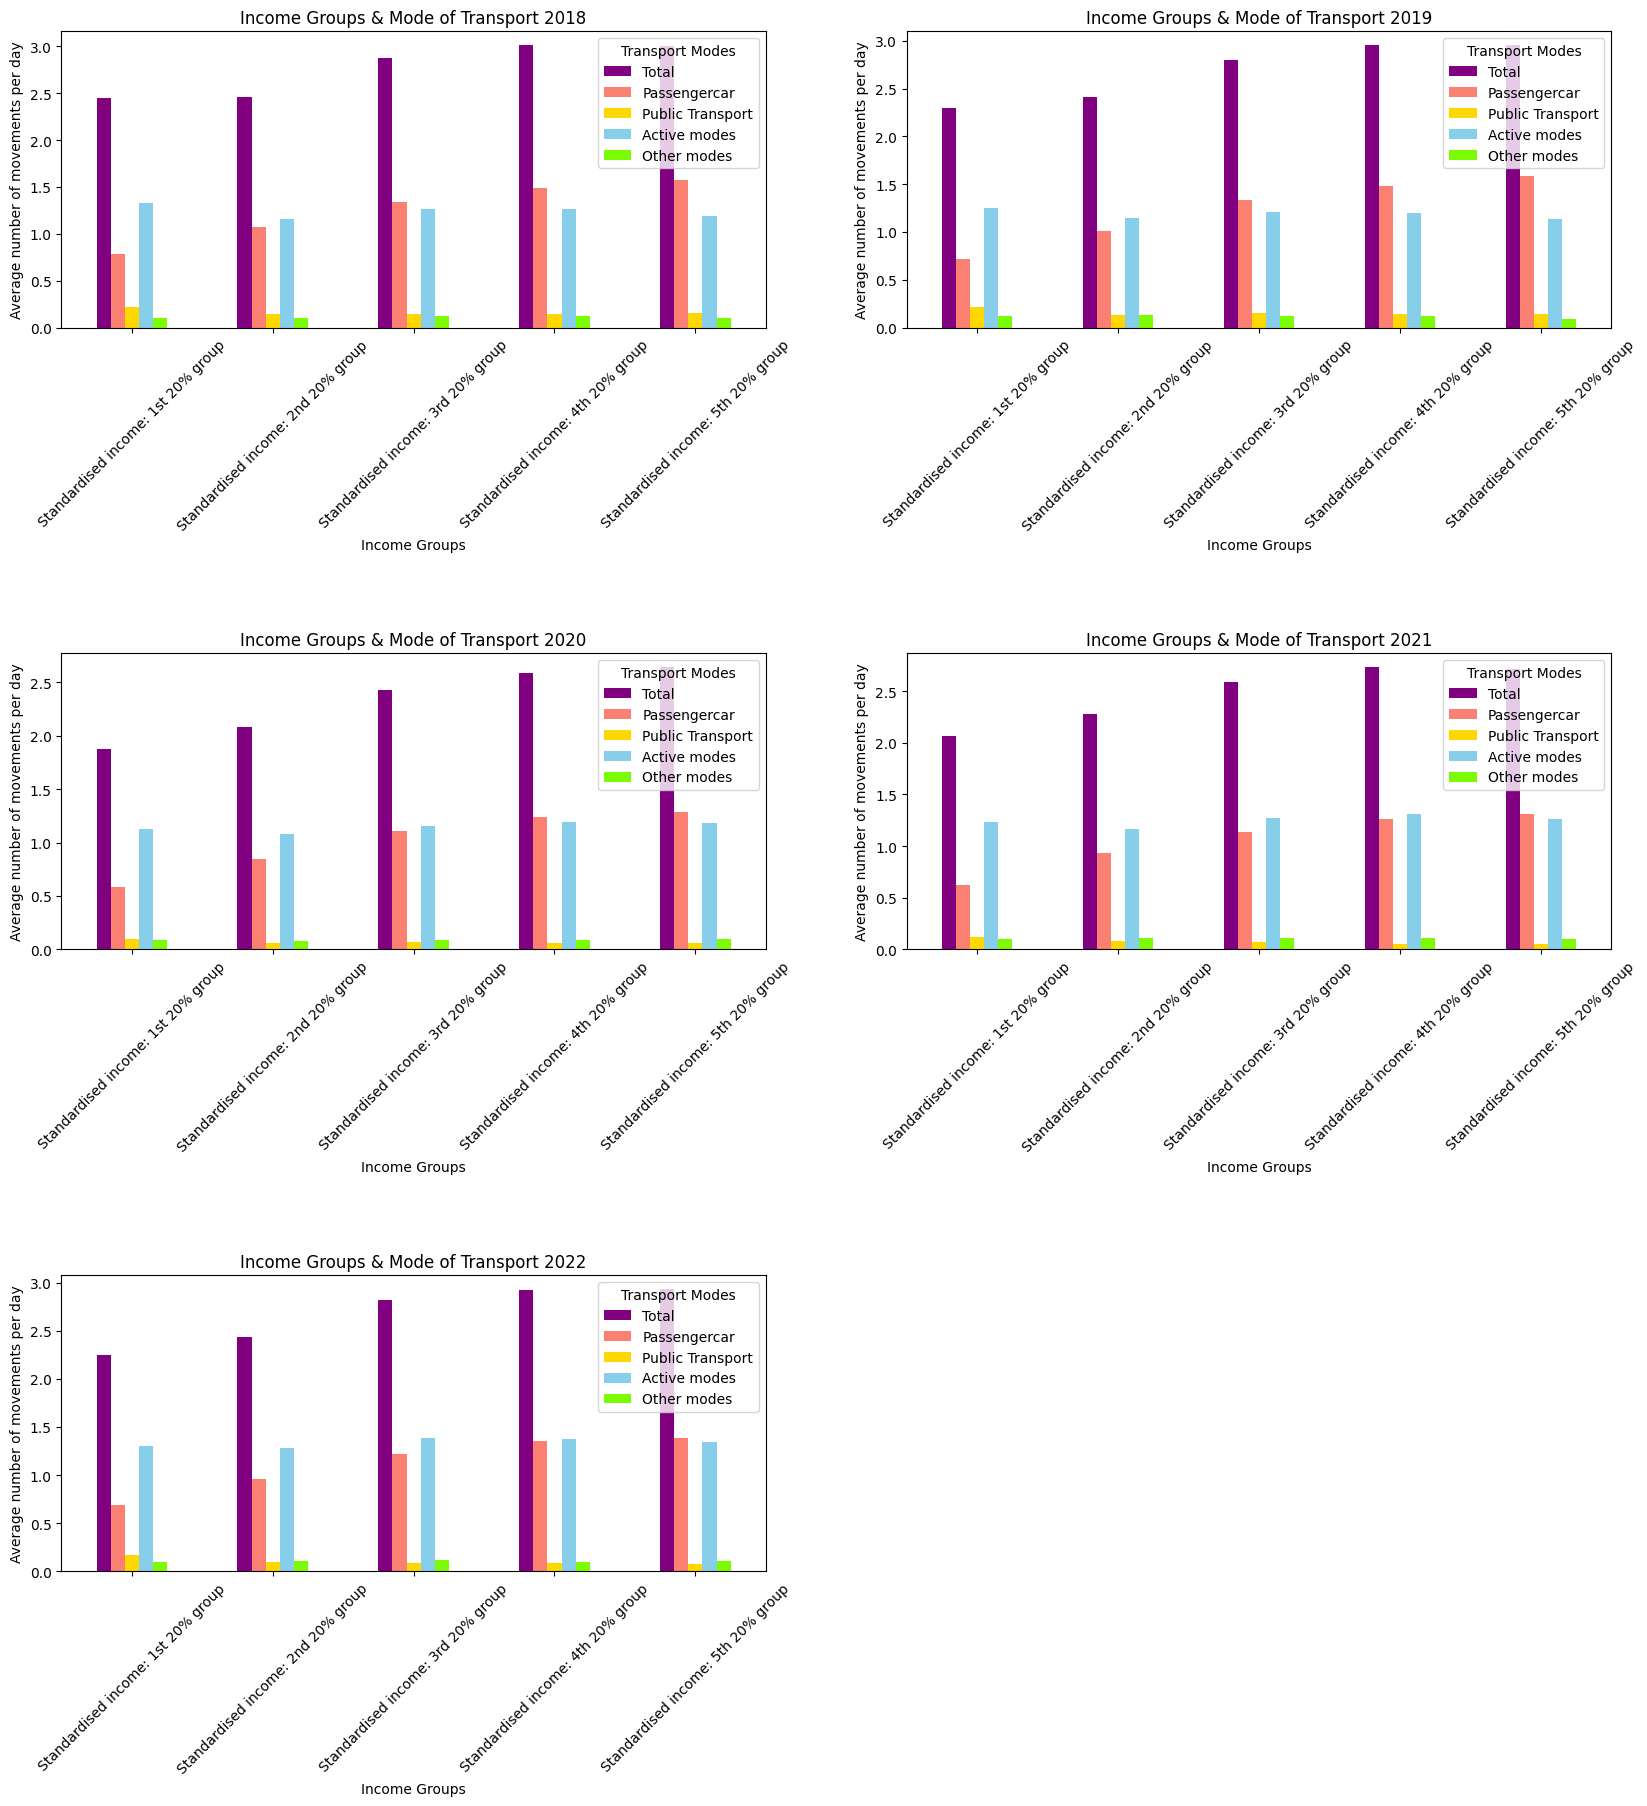

In [18]:
# Filter Income Groups
income_groups = [
    "Standardised income: 1st 20% group",
    "Standardised income: 2nd 20% group",
    "Standardised income: 3rd 20% group",
    "Standardised income: 4th 20% group",
    "Standardised income: 5th 20% group"
]

# Filtered DataFrame for each year
dfs = [transport_2018, transport_2019, transport_2020, transport_2021, transport_2022]

# Changing layout of plots for better readability 
fig, axes = plt.subplots(3, 2, figsize=(20, 20)) # Two rows to show the 5 plots to prevent cluttering
fig.subplots_adjust(hspace=1.1)  
axes = axes.flatten()

for i, ax in enumerate(axes):
    if i < len(dfs):
        df = dfs[i]
        transport_filtered = df.loc[income_groups]
        transport_filtered.plot(kind='bar', stacked=False, color=["purple", "salmon", "gold", "skyblue", "lawngreen"], ax=ax)
        ax.set_title(f"Income Groups & Mode of Transport {2018 + i}")
        ax.set_xlabel("Income Groups")
        ax.set_ylabel("Average number of movements per day")
        ax.legend(title='Transport Modes', loc='upper right')
        ax.tick_params(axis='x', rotation=45)
    else:
        fig.delaxes(ax)  

# Remove the large plots 
plt.close('all')

# Display the combined grid of small plots
display(fig)

**Transport Mode**

The highest income group also has the biggest share in overall transport, as well as the biggest share in car transport. This makes sense as car transport is the most expensive mode out of the four options. simultaneously, it is also true that the lowest income group has the smallest share in car use for the same reasons. 

The use of active modes differs per income group and doesn't seem to have a connection with the height of the income. Since the 3rd income group seems to have roughly the same use of active transport modes as the 1st income group. 

**COVID-19 Impact**

COVID seems to have had a bigger impact on the lower income groups than on the higher income groups. The impact COVID had is not very obvious, as the division over the transport modes for each income group stays roughly the same. But the average number of movements did increase significantly between 2018 and 2020.

COVID has had a visible impact on the public transport mode for the 1st income group. This bar(yellow) is significantly smaller in the years 2020 & 2021 than in the 'COVID-free' years. 

**Trends**

A trend that is visible in all the 5 plots, is that the share in overall transport increases as the income inceases. The highest income group has the highest share in transport. This also goes for the share in car transport: if the income increases, the use of car transport increases. 

If the income increases, the use of public transport decreases. 

#### Public transport vs. car ownership vs neither

The following code shows one chart that compares the number of people having a PT Student Card owners, people who have Car and people who have neither during the years. **What is the influence of having PT Student Card comparing ownering a car or Neither?**

In [19]:
# Data for 'PT-studentcard: Weekday subscription,' 'Drivers licence; owns own car,' 'No drivers license,' and 'Drivers license; no car' for each year
years = ['2018', '2019', '2020', '2021', '2022']

# Extract the "Total" row for each category
pt_student_card = [transport_2018.loc['PT-studentcard: Weekday subscription', 'Total'],
                   transport_2019.loc['PT-studentcard: Weekday subscription', 'Total'],
                   transport_2020.loc['PT-studentcard: Weekday subscription', 'Total'],
                   transport_2021.loc['PT-studentcard: Weekday subscription', 'Total'],
                   transport_2022.loc['PT-studentcard: Weekday subscription', 'Total']]

owning_car = [transport_2018.loc['Drivers licence; owns own car', 'Total'],
             transport_2019.loc['Drivers licence; owns own car', 'Total'],
             transport_2020.loc['Drivers licence; owns own car', 'Total'],
             transport_2021.loc['Drivers licence; owns own car', 'Total'],
             transport_2022.loc['Drivers licence; owns own car', 'Total']]

# Sum the "No Drivers License" and "Drivers License (No Car)"
no_drivers_license = [transport_2018.loc['No drivers license', 'Total'],
                     transport_2019.loc['No drivers license', 'Total'],
                     transport_2020.loc['No drivers license', 'Total'],
                     transport_2021.loc['No drivers license', 'Total'],
                     transport_2022.loc['No drivers license', 'Total']]

drivers_license_no_car = [transport_2018.loc['Drivers license; no car', 'Total'],
                          transport_2019.loc['Drivers license; no car', 'Total'],
                          transport_2020.loc['Drivers license; no car', 'Total'],
                          transport_2021.loc['Drivers license; no car', 'Total'],
                          transport_2022.loc['Drivers license; no car', 'Total']]

no_drivers_license_and_license_no_car = [no + no_car for no, no_car in zip(no_drivers_license, drivers_license_no_car)]

# Create a DataFrame for the data
data = pd.DataFrame({'Year': years,
                     'PT Student Card': pt_student_card,
                     'Owns a Car': owning_car,
                     'Neither': no_drivers_license_and_license_no_car})


# Create an interactive line chart using Plotly Express with custom colors
fig = px.line(data, x='Year', y=data.columns[1:], labels={'value': 'Total Count'},
              title='PT Student Card vs Car Ownership vs Neither over the Years',
              color_discrete_map={'PT Student Card': 'salmon', 'Owns a Car': 'gold', 'Neither': 'skyblue'})
fig.update_traces(mode='markers+lines', marker=dict(size=10))
fig.show()


**Transport Mode**

The chart demonstrates that the declining percentages of people having PT student card and people who own a car, from 2018 to 2020 can be attributed to the impact of COVID-19. However, from 2020 to 2022, there is a noticeable rebound in percentages, indicating a gradual recovery towards the pre-COVID-19 levels. The percentage of people having neither despite the fact it was declined, it increased as the other two variables but not as in previous Covid-19 levels.

**COVID-19 Impact** 

The initial decline in peoples travels owning PT Student card and people own a car, was primarily due to the COVID-19 pandemic, which led to decreased commuting. From 2020 to 2022, there was a resurgence across all three variables, signaling a return to more typical transportation behaviors.

**Trend**

The data shows a consistent pattern over the years, characterized by two-year periods of declining, followed by two-year periods of increasing. These fluctuations in the numbers can be attributed to the consequences of the COVID-19 pandemic. People tends to travell less during that period but after 2020 the percentage arrived the pre-Covid-19 levels.


#### Migration background
The following code shows three plots, made up of the groups with a different Migration background (Netherlands, Western & Non-western) and their Choice of Transport Mode. Each of the plots compare the average number of movements for each of the different years. **Does the choice of transport mode differ for the different migration backgrounds?**

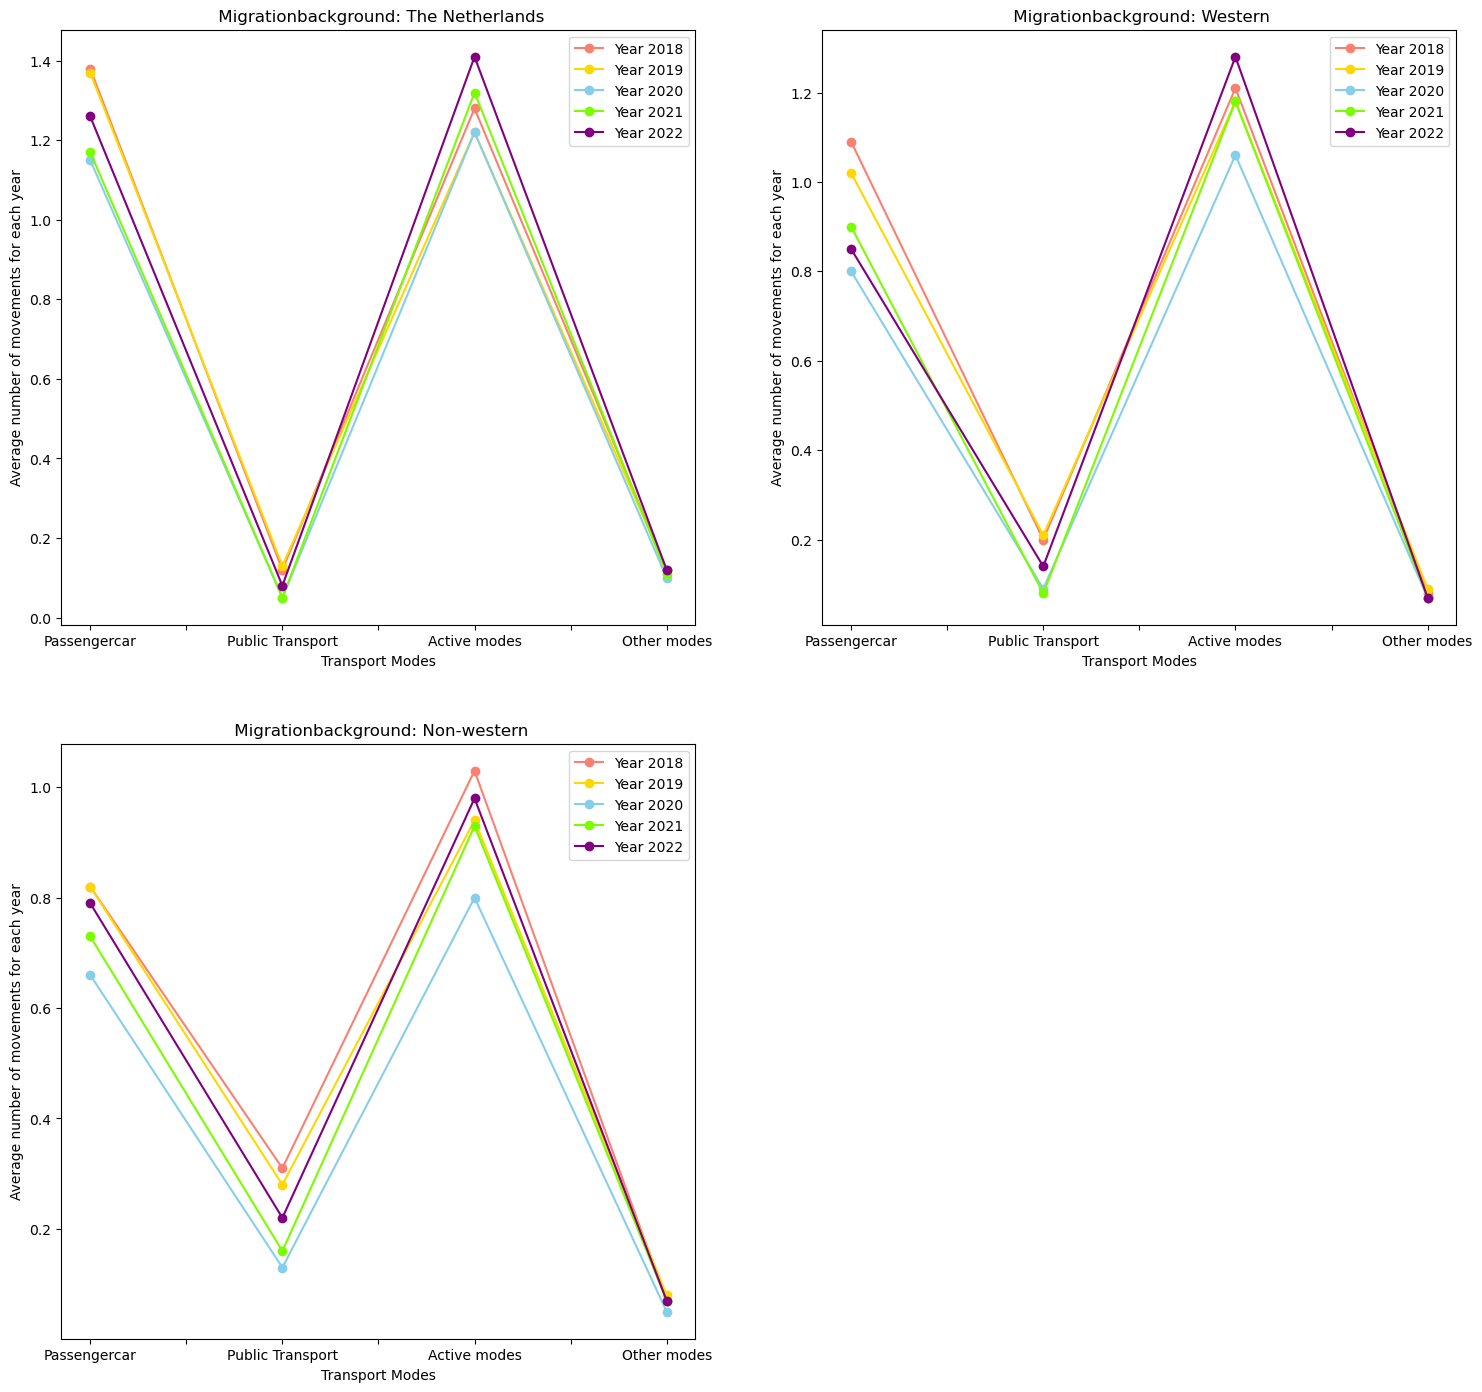

In [15]:
# Filter the three different Migration backgrounds
migration_background = [
    "Migrationbackground: The Netherlands",
    "Migrationbackground: Western",
    "Migrationbackground: Non-western",
]

# Create a grid for the three line plots
fig, axes = plt.subplots(2, 2, figsize=(18, 17))
fig.delaxes(axes[1, 1])  # Remove the fourth empty subplot
colors = ["salmon", "gold", "skyblue", "lawngreen", "purple"]

for i, mbg in enumerate(migration_background):
    ax = axes[i // 2, i % 2]
    ax.set_title(f" {mbg}")
    ax.set_xlabel("Transport Modes")
    ax.set_ylabel("Average number of movements for each year")
    
    for j, df in enumerate(dfs):
        transport_filtered = df.loc[mbg]
        transport_filtered = transport_filtered.T 
        transport_filtered = transport_filtered.drop("Total", errors="ignore")
        transport_filtered.plot(kind='line', color=colors[j], ax=ax, marker='o', label=f"Year {2018 + j}")

    # Create a legend for each subplot
    ax.legend(loc='upper right')

# Hide the individual large plots
plt.close('all')

# Display the combined grid of small plots
display(fig)

**Transport modes**

What becomes visible by looking at the plots is that people with a Dutch migration background have a higher share in overall transport than people with a western or non-western migration background: they have the biggest share in car transport & active modes for all five years. This native group however makes the least use of public transport of the three groups, Non-western people have the biggest share in the public transport mode, in 2018 almost two times bigger than the other two groups.  

**COVID impact**

Another remarkable point that is visible in these linear plots, is the impact COVID has had on the average number of movements. The year 2020(blue line) has the lowest scores on all of the transport modes, for all three of the migration backgrounds. It also shows that the group with a Non-western migration background was hit harder by COVID than the other two groups. Something that confirms COVID to be the cause of this trend, is the fact that the 'post-COVID' year 2022(purple line) scores higher than the COVID-years. 

**Trends**

It seems that the active modes of transport have become more popular than car transport over the last five years in the groups with a Dutch & Western migration background. 

### Subquestion 3: Is there a significant difference over the years in mode choice?

Want the following plots:
- 1 barplot with a bar for each year, stacked different modes. Absolute numbers.
- Same, but with normalised numbers.
- Possibly also still something for specific transport modes

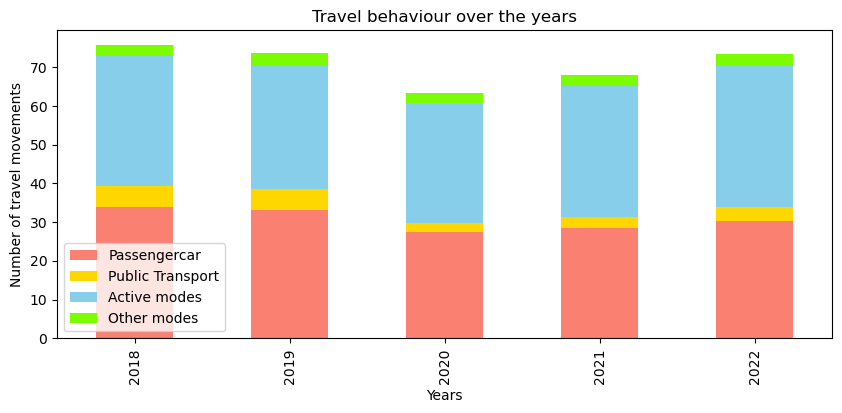

In [16]:
combined_df=pd.DataFrame()
i=2018
for frame in [transport_2018, transport_2019, transport_2020, transport_2021, transport_2022]:
    data = [sum(frame["Passengercar"]), sum(frame["Public Transport"]), sum(frame["Active modes"]), sum(frame["Other modes"])]
    combined_df[str(i)] = data
    i += 1

index_names = ["Passengercar", "Public Transport", "Active modes", "Other modes"]
combined_df.index = index_names

combined_df.T.plot(kind = "bar", stacked = True, color = ["salmon", "gold", "skyblue", "lawngreen"], 
                  figsize = (10,4), fontsize = 10)
plt.title("Travel behaviour over the years")
plt.xlabel("Years")
plt.ylabel("Number of travel movements")
plt.show()

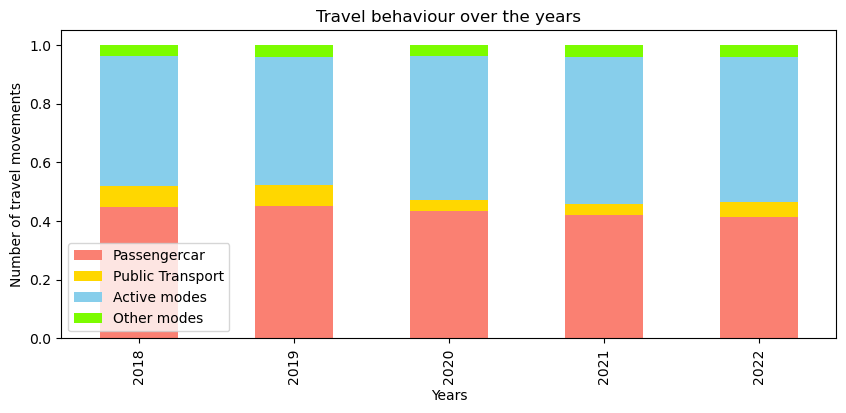

In [17]:
def normal_rows_years(df):
    normal_df = df.div(df.sum(axis = 1), axis = 0)
    return normal_df

normal_combined_df=normal_rows_years(combined_df.T)

normal_combined_df.plot(kind = "bar", stacked = True, color = ["salmon", "gold", "skyblue", "lawngreen"], 
                  figsize = (10,4), fontsize = 10)
plt.title("Travel behaviour over the years")
plt.xlabel("Years")
plt.ylabel("Number of travel movements")
plt.show()

## Conclusion

### Subquestion 4: Can we use machine learning methods to classify which personal characteristics correlate the most with the various modes?
We start by using the normalized data from the previous subquestion, then we show a correlation plot of the to get a better understanding of the relationship between the different modes based on the personal characteristics data. Next, we determine the number of clusters to make by using the elbow method and calculating the BIC, Silhouette and Davies score for different number of clusters. Based on these results we decide on the number of clusters k, which we then use to make k clusters sing the k-means clustering machine learning technique. To anwer this subquestion the results are visualized and discussed. 

Based on subquestion 3 and the goal of subquestion 4 we only do this for the 2018 data. Since there were not any significant differences on mode choice throughout the years, only for the number of trips, we decided to only test this machine learning method on the 2018 data. For further research the same method can be applied to the other years.

We start by plotting the correlation between the modes based on the number of movements for every personal characteristic, to obtain a better understanding of the correlation between the modes before clustering.

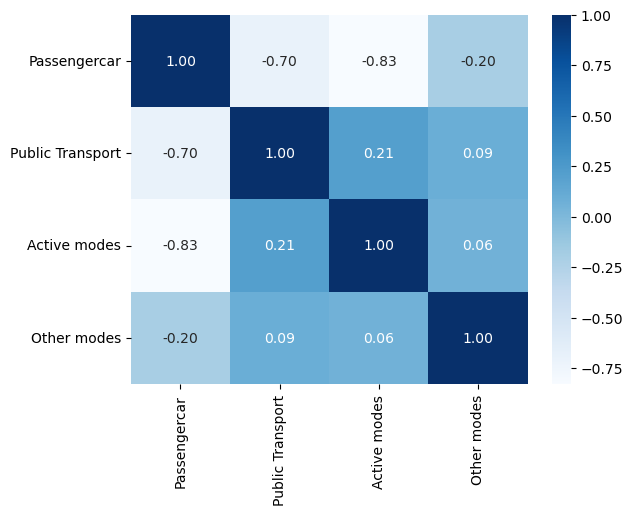

In [18]:
# Correlation plot of mode choices
fig, axes = plt.subplots(1)
corr_2018 = normal_2018.corr()
heatmap_2018 = sns.heatmap(round(corr_2018, 2), annot=True, cmap='Blues', ax=axes, fmt='.2f')

The heatmap plot reveals several significant correlations among the four transportation modes, shedding light on travel behavior. Notably, there is a robust negative correlation between public transport and passenger car usage. This suggests that individuals who opt for public transport are unlikely to select a car for their subsequent trip. The same trend is observed for active modes, such as biking and walking, which also exhibit a negative correlation with passenger car usage. In contrast, there is a modest positive correlation between active modes and public transport, indicating that those who favor biking or walking are more inclined to use public transportation for their next journey. A slightly negative correlation emerges between other modes and passenger cars. For the remaining combinations, the correlations hover around zero, signifying their independence from one another.

Next, we start the clustering method by determining the number of clusters using the mentioned techniques and scores.

#### K-means clustering

C:\Users\Gebruiker\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



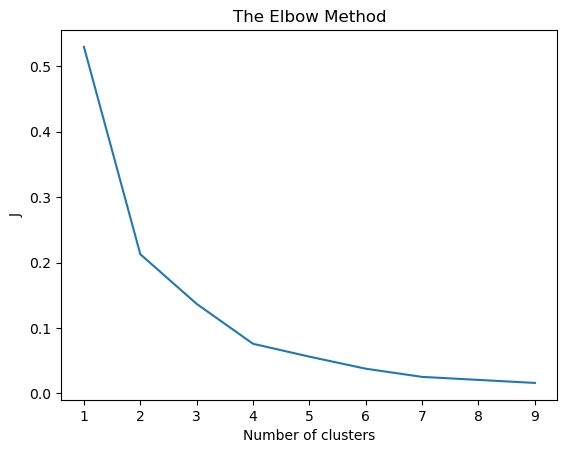

In [19]:
# elbow method to determine number of clusters
wcss = []
N_max = 10
for i in range(1, N_max):
    kmeans = KMeans(n_clusters=i,random_state=1).fit(normal_2018)
    wcss.append(kmeans.inertia_)
    
plt.figure()
plt.plot(range(1, N_max),wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('J')
plt.show()

# the warning that is obtained is researched: whatever the memory leak is, it's tiny.
# For short-running jobs, the script will probably end before the leak gets too bad, and the process will free the memory.

The rule of thumb for the elbow method is to choose the number of clusters where there is a kink in the graph. In this case there is a kink at k = 2, a small kink at k = 3 and large one at k = 4. To be able to make a better choice we also look at some scores to determine the number of clusters.

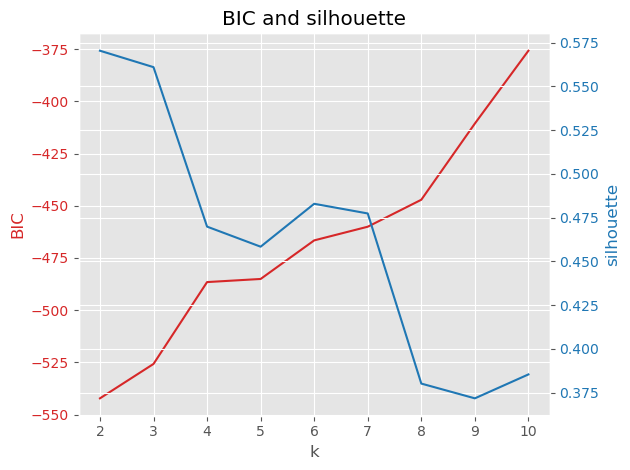

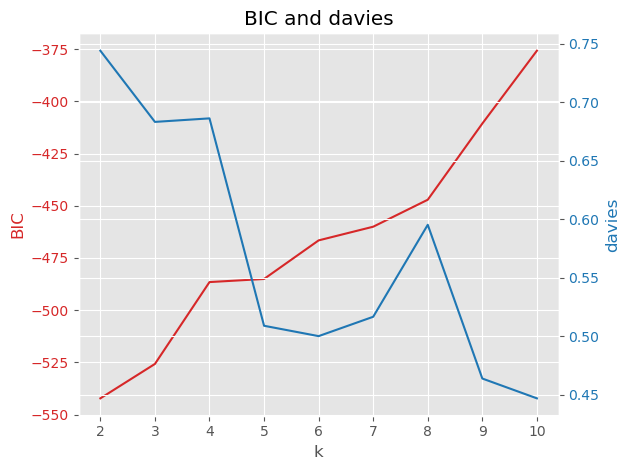

In [20]:
# calculate different types of scores to decide on number of clusters
def get_km(k, X):
    km = KMeans(n_clusters=k, random_state=1)
    km.fit(X)
    return km

def get_bic(k, X):
    gmm = GaussianMixture(n_components=k, init_params='kmeans', random_state=1)
    gmm.fit(X)
    return gmm.bic(X)

def get_score(k, X):
    km = get_km(k, X)
    y_pred = km.predict(X)
    bic = get_bic(k, X)
    sil = silhouette_score(X, y_pred)
    db = davies_bouldin_score(X, y_pred)
    return k, bic, sil, db

scores_df = pd.DataFrame([get_score(k, normal_2018) for k in range(2, 11)],
                  columns=['k', 'BIC', 'silhouette','davies'])

plt.style.use('ggplot')

def plot_compare(df, y1, y2, x, fig, ax1):
    ax1.plot(df[x], df[y1], color='tab:red')
    ax1.set_title(f'{y1} and {y2}')
    ax1.set_xlabel(x)
    ax1.set_ylabel(y1, color='tab:red')
    ax1.tick_params(axis='y', labelcolor='tab:red')

    ax2 = ax1.twinx()
    ax2.plot(df[x], df[y2], color='tab:blue')
    ax2.set_ylabel(y2, color='tab:blue')
    ax2.tick_params(axis='y', labelcolor='tab:blue')

def plot_result(df, y1, y2, x):
    fig, axes = plt.subplots(1)
    plot_compare(df, y1, y2, x, fig, axes)
    plt.tight_layout()
    
plot_result(scores_df, 'BIC', 'silhouette', 'k')
plot_result(scores_df, 'BIC', 'davies', 'k')

# BIC: lower is better
# silhouette: higher is better
# davies: lower is better

To interpret the test results it is crucial to know that for the BIC score, the lower is number is better. For the Silhouette score, the higher the number is better and for Davies the lower is better. From the plots it can be seen that k = 3 and k = 4 clusters are the candidates that result in good scores.

Another factor that may be taken into account for determining the number of clusters is the problem definition. Does a specific number of clusters align better with the natural grouping of the data, making it more interpretable in the context of our research question? In our case k = 3 or k = 4 would both be interpretable, since we are looking at three distinct modes (car, public transport and active modes), plus the other mode category that could make k = 4 suitable.

Combining all these results we have decided to choose k = 4 clusters.

Next we apply the 4-means clustering technique in which the data is clustered into 4 clusters, where every personal characteristic will be assigned to one of the clusters. By comparing the clusters correlation with the various modes, we could draw conclusions from which personal characteristics most influence the mode choice of individuals.

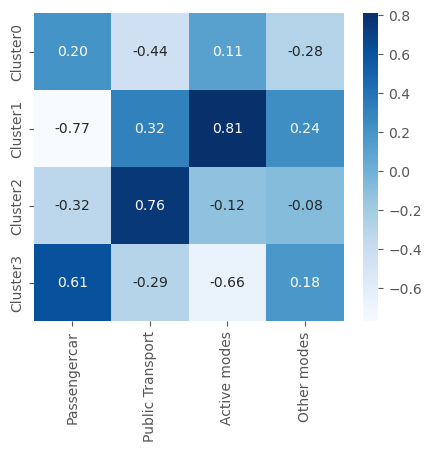

In [21]:
# apply k-means clustering technique
kmeans = KMeans(n_clusters=4, random_state=1).fit(normal_2018)

# obtain clusters and add label to data
normal_2018['cluster'] = kmeans.labels_

# make binary columns in data for each cluster 
normal_2018['Cluster0'] = np.where(normal_2018['cluster'] != 0, 0, 1)
normal_2018['Cluster1'] = np.where(normal_2018['cluster'] != 1, 0, 1)
normal_2018['Cluster2'] = np.where(normal_2018['cluster'] != 2, 0, 1)
normal_2018['Cluster3'] = np.where(normal_2018['cluster'] != 3, 0, 1)

# make cluster vs. mode correlation plot to see which modes are most present in each cluster
fig, axes = plt.subplots(figsize = (5,4))
correlation_table = normal_2018.corr()
corr2 = correlation_table.drop(correlation_table.index[range(5)])
corr3 = corr2.drop(columns=corr2.columns[4:])
corr_m = sns.heatmap(round(corr3, 2), annot=True, cmap='Blues', ax=axes, fmt='.2f')

From this heatmap, the following patterns emerge:

- Cluster 0 demonstrates a lack of significant correlation with any of the modes, implying that the characteristics within this cluster are not strongly associated with a particular mode choice.
- Cluster 1 exhibits a strong correlation with active modes, suggesting that individuals with the personal characteristics in this cluster are highly inclined to select an active mode for their travels.
- Cluster 2 displays a strong correlation with public transport, indicating that individuals with the personal characteristics in this cluster are most likely to opt for public transport for their journeys.
- Cluster 3 reveals a substantial correlation with passenger cars, implying that individuals with the personal characteristics in this cluster are strongly inclined to choose a car for their travels.

Next, we will delve deeper into each of these four clusters to further investigate the trends mentioned above.

In [22]:
# make dataframe for every cluster including personal characteristics corresponding to cluster
cluster0 = normal_2018.loc[normal_2018['cluster'] == 0].drop(columns=normal_2018.columns[4:])
cluster1 = normal_2018.loc[normal_2018['cluster'] == 1].drop(columns=normal_2018.columns[4:])
cluster2 = normal_2018.loc[normal_2018['cluster'] == 2].drop(columns=normal_2018.columns[4:])
cluster3 = normal_2018.loc[normal_2018['cluster'] == 3].drop(columns=normal_2018.columns[4:])

In [23]:
# make functions for analysis

# number of characteristics in cluster
def length(cluster):
    output = 'The number of characteristics that are in this cluster is equal to %i from the %i characteristics in the dataset.' % (len(cluster), len(normal_2018))
    print(output)
    
# average normalized distribution of movements over the four different modes in cluster
def distribution(cluster):
    distribution = {}
    for i in cluster:
        distribution[str(i)] = cluster[i].mean()
    return distribution
    
# function that returns top two modes with most movements in cluster
def mode_choice(cluster):
    dist = distribution(cluster)
    sort = sorted(((v,k) for k,v in dist.items()))
    mode1 = max(dist, key=dist.get)
    mode2 = sort[-2][1]
    return mode1, mode2

# print characteristics (index) in cluster
def characteristics(cluster):
    characteristics = cluster.index.values.tolist()
    return characteristics

# three most influential characteristics for mode choice in cluster
def significant_characteristics(cluster):
    lst = []
    chars = dict(cluster[str(mode_choice(cluster)[0])].nlargest(3)).keys()
    for key in characteristics:
        lst.append(key)
    print('The three characteristics with highest movements for mode "%s" are "%s", "%s" and "%s".' % (str(mode_choice(cluster)[0]), lst[0], lst[1], lst[2])) 

We start by looking at the number of characteristics that are in each cluster.

In [24]:
length(cluster0)
length(cluster1)
length(cluster2)
length(cluster3)

The number of characteristics that are in this cluster is equal to 12 from the 27 characteristics in the dataset.
The number of characteristics that are in this cluster is equal to 4 from the 27 characteristics in the dataset.
The number of characteristics that are in this cluster is equal to 3 from the 27 characteristics in the dataset.
The number of characteristics that are in this cluster is equal to 8 from the 27 characteristics in the dataset.


This distribution results in the following percentages across the clusters:
- The majority, 44%, of the characteristics belong to cluster 0.
- Cluster 3 follows with 30% of the characteristics.
- Cluster 2 accounts for 11% of the characteristics.
- Lastly, 15% of the characteristics fall into cluster 1.

Consequently, cluster 0 contains the largest share of characteristics, followed by cluster 3, cluster 2, and cluster 1. The next step is to identify the most commonly chosen mode within each cluster to assess whether these clusters align with distinct mode preferences.

In [25]:
print(characteristics(cluster0))
print('The mode choice of cluster 0 is mostly %s, in second place is %s.' % (mode_choice(cluster0)[0], mode_choice(cluster0)[1]))

print(characteristics(cluster1))
print('The mode choice of cluster 1 is mostly %s, in second place is %s.' % (mode_choice(cluster1)[0], mode_choice(cluster1)[1]))

print(characteristics(cluster2))
print('The mode choice of cluster 2 is mostly %s, in second place is %s.' % (mode_choice(cluster2)[0], mode_choice(cluster2)[1]))

print(characteristics(cluster3))
print('The mode choice of cluster 3 is mostly %s, in second place is %s.' % (mode_choice(cluster3)[0], mode_choice(cluster3)[1]))

['Age: 65 years or older', 'Migrationbackground: The Netherlands', 'Migrationbackground: Western', 'Standardised income: 2nd 20% group', 'Standardised income: 3rd 20% group', 'Standardised income: 4th 20% group', 'PT-studentcard: None', 'Education level: Low', 'Education level: High', 'Participation: Working 12 to 30 h/w', 'Participation: retired', 'Participation: Other']
The mode choice of cluster 0 is mostly Passengercar, in second place is Active modes.
['Standardised income: 1st 20% group', 'Participation: student', 'Drivers license; no car', 'No drivers license']
The mode choice of cluster 1 is mostly Active modes, in second place is Passengercar.
['Age: 18 to 25 years', 'Migrationbackground: Non-western', 'PT-studentcard: Weekday subscription']
The mode choice of cluster 2 is mostly Active modes, in second place is Passengercar.
['Age: 25 to 35 years', 'Age: 35 to 50 years', 'Age: 50 to 65 years', 'Standardised income: 5th 20% group', 'Education level: middle', 'Participation: Wo

These findings reveal the personal characteristics associated with each cluster and the top two most commonly chosen modes within them:
- Cluster 0: (Passengercar, active modes)
    + Age: 65 years or older
    + Migrationbackground: The Netherlands
    + Migrationbackground: Western
    + Standardised income: 2nd 20% group
    + Standardised income: 3rd 20% group
    + Standardised income: 4th 20% group
    + PT-studentcard: None
    + Education level: Low
    + Education level: High
    + Participation: Working 12 to 30 h/w
    + Participation: retired
    + Participation: Other
- Cluster 1: (Active modes, passengercar)
    + Standardised income: 1st 20% group
    + Participation: student
    + Drivers license; no car
    + No drivers license
- Cluster 2: (Active modes, passengercar)
    + Age: 18 to 25 years
    + Migrationbackground: Non-western
    + PT-studentcard: Weekday subscription
- Cluster 3: (Passengercar, active modes)
    + Age: 25 to 35 years
    + Age: 35 to 50 years
    + Age: 50 to 65 years
    + Standardised income: 5th 20% group
    + Education level: middle
    + Participation: Working 30+ h/w
    + Drivers license; owns own car
    + Drivers license; car in household
 
However, despite these distinct profiles, it is apparent that the clusters do not correspond as expected based on the correlation table. To gain a deeper understanding of the mode choices within each cluster, we will further examine the distribution of mode choices and visualize them in a barplot.

In [26]:
# make interactive barplot using distribution data of different clusters
data = {
    'Cluster': ['Cluster0', 'Cluster1', 'Cluster2', 'Cluster3'],
    'Passengercar': [distribution(cluster0)['Passengercar'], distribution(cluster1)['Passengercar'], 
                     distribution(cluster2)['Passengercar'], distribution(cluster3)['Passengercar']],
    'Public Transport': [distribution(cluster0)['Public Transport'], distribution(cluster1)['Public Transport'], 
                         distribution(cluster2)['Public Transport'], distribution(cluster3)['Public Transport']],
    'Active Modes': [distribution(cluster0)['Active modes'], distribution(cluster1)['Active modes'], 
                     distribution(cluster2)['Active modes'], distribution(cluster3)['Active modes']],
    'Other Modes': [distribution(cluster0)['Other modes'], distribution(cluster1)['Other modes'], 
                    distribution(cluster2)['Other modes'], distribution(cluster3)['Other modes']]
}

df = pd.DataFrame(data)
colors = ["salmon", "gold", "skyblue", "lawngreen"]
df = pd.melt(df, id_vars=['Cluster'], var_name='Mode', value_name='Count')

# create an interactive barplot using Plotly Express
fig = px.bar(df, x='Cluster', y='Count', color='Mode',
             color_discrete_sequence=colors,
             title='Movements by Mode in Each Cluster',
             labels={'Cluster': 'Cluster', 'Count': 'Count'},
             category_orders={'Cluster': ['Cluster0', 'Cluster1', 'Cluster2', 'Cluster3']}
            )
fig.show()

Analyzing the plot, it becomes evident that passengercar and active modes are dominant across the clusters. Notably, cluster 2 stands out with a substantial portion of public transport users. Therefore, the personal characteristics within cluster 2 likely correspond to a preference for public transport. Cluster 0, on the other hand, displays a considerable divide between passengercar and active modes, making it less indicative of a specific mode choice. Meanwhile, cluster 1 distinctly aligns with personal characteristics that favor active modes, while cluster 3 primarily reflects passengercar usage.

In summary, the identified personal characteristics can be associated with three primary modes, excluding other modes. These clusters offer valuable insights into mode choice patterns based on specific attributes:

- Passengercar:
    + Age: 25 to 35 years
    + Age: 35 to 50 years
    + Age: 50 to 65 years
    + Standardised income: 5th 20% group
    + Education level: middle
    + Participation: Working 30+ h/w
    + Drivers license; owns own car
    + Drivers license; car in household
- Public transport:
    + Age: 18 to 25 years
    + Migrationbackground: Non-western
    + PT-studentcard: Weekday subscription
- Active modes:
    + Standardised income: 1st 20% group
    + Participation: student
    + Drivers license; no car
    + No drivers license

These results can be explained by the following reasoning:
- **Passengercar**: Individuals aged 25 to 65 years with middle-level education and belonging to the 5th 20% income group are more likely to choose passenger cars for daily transportation. Full-time employees working 30+ hours per week, often with driver's licenses and car access, find car ownership practical for their commuting and family needs.
- **Public transport**: Young adults aged 18 to 25 years, especially those with non-western migration backgrounds, prefer public transport due to financial constraints, urban living, and cultural familiarity. Students often rely on public transport for school or university commutes, facilitated by weekday subscriptions.
- **Active mode**: Individuals in the 1st 20% income group, typically students without driver's licenses or cars, favor active modes like walking or biking. Limited financial resources and a focus on local commuting make active modes a practical and economical choice for this group.

### Comparison to results previous subquestions
Something here about the comparison

For further research more in depth analyses can be done, but or the scope of this project we will conclude this subquestion here. Something on the conclusion if machine learning methods can help...

# Conlusion
We still need to write something here.

## Limitations and recommendations
We still need to write something here.

# References

[1] NS wil voorstel spitsheffing beperken tot €2,50 per rit (businessinsider.nl)(https://www.businessinsider.nl/ns-wil-voorstel-spitsheffing-beperken-tot-e250-per-rit-veel-verzet-in-tweede-kamer/)

[2] StatLine - Mobiliteit; per persoon, persoonskenmerken, vervoerwijzen en regio's (cbs.nl) (https://opendata.cbs.nl/statline/#/CBS/nl/dataset/84709NED/table?ts=1696241475558)